<a href="https://colab.research.google.com/github/AlyonaKap/ml-projects/blob/main/Data_balancing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA and Class Imbalance Handling in Insurance Data

So we are going to work with an Imbalanced Insurance Data from Kaggle: https://www.kaggle.com/datasets/arashnic/imbalanced-data-practice/data. Our task is to do a small Exploratory Data Analysis (EDA), detect and handle the imbalanced class problem and build some prediction models.

In [ ]:
#Libraries for working with data and making plots
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive

#Transform features by scaling each feature to a given range
from sklearn.preprocessing import MinMaxScaler

#Oversampling methods for class balancing
from imblearn.over_sampling import SMOTE, ADASYN

#Prediction models and evaluation tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# **EDA**

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab/aug_train.csv')

In [ ]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,167647,Male,22,1,7.0,1,< 1 Year,No,2630.0,152.0,16,0
1,17163,Male,42,1,28.0,0,1-2 Year,Yes,43327.0,26.0,135,0
2,32023,Female,66,1,33.0,0,1-2 Year,Yes,35841.0,124.0,253,0
3,87447,Female,22,1,33.0,0,< 1 Year,No,27645.0,152.0,69,0
4,501933,Male,28,1,46.0,1,< 1 Year,No,29023.0,152.0,211,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382154 entries, 0 to 382153
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    382154 non-null  int64  
 1   Gender                382154 non-null  object 
 2   Age                   382154 non-null  int64  
 3   Driving_License       382154 non-null  int64  
 4   Region_Code           382154 non-null  float64
 5   Previously_Insured    382154 non-null  int64  
 6   Vehicle_Age           382154 non-null  object 
 7   Vehicle_Damage        382154 non-null  object 
 8   Annual_Premium        382154 non-null  float64
 9   Policy_Sales_Channel  382154 non-null  float64
 10  Vintage               382154 non-null  int64  
 11  Response              382154 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 35.0+ MB


General information:

The dataset contains information about clients of an insurance company, including their demographics (gender, age, region code), vehicle details (damage) and policy information (insurance contribution and how long the client has been with the company). All these characteristics are represented as variables.  

The column **Response** is the target feature (dependent variable). It shows whether the client is interested in purchasing vehicle insurance.

In [ ]:
df.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,382154.000000,382154.000000,382154.000000,382154.000000,382154.000000,382154.000000,382154.000000,382154.000000,382154.000000
mean,234392.953477,38.545691,0.998108,26.406867,0.489182,30711.271362,111.939812,154.189429,0.163811
std,139527.487326,15.226897,0.043455,13.181241,0.499884,17061.595532,54.286511,83.735107,0.370104
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,115006.250000,25.000000,1.000000,15.000000,0.000000,24546.000000,26.000000,81.000000,0.000000
50%,230461.500000,36.000000,1.000000,28.000000,0.000000,31692.000000,145.000000,154.000000,0.000000
75%,345434.750000,49.000000,1.000000,35.000000,1.000000,39447.750000,152.000000,227.000000,0.000000
max,508145.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


**Handling missing and duplicates data**

In [ ]:
df.isnull().sum()

,0
id,0
Gender,0
Age,0
Driving_License,0
Region_Code,0
Previously_Insured,0
Vehicle_Age,0
Vehicle_Damage,0
Annual_Premium,0
Policy_Sales_Channel,0


In [ ]:
df.duplicated().sum()

np.int64(0)

The dataset has 0 na and duplicate values

**Exploring data characteristics**

Let's check the distribution of numerical characteristics

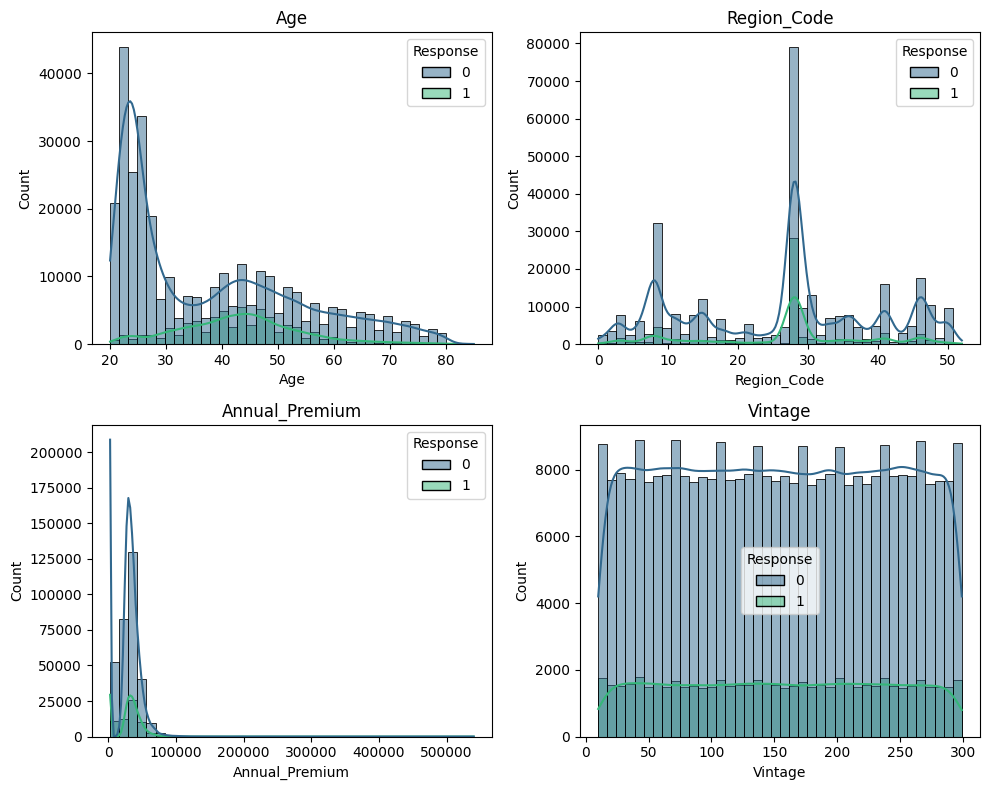

In [ ]:
num_cols = ['Age', 'Region_Code', 'Annual_Premium', 'Vintage']

fig, axes = plt.subplots(2, 2, figsize = (10,8))
axes = axes.flatten()

for col, ax in zip(num_cols, axes):
  sns.histplot(x = col, data = df, ax = ax, kde = True, hue = 'Response',
               bins = 40, palette = 'viridis')
  ax.set_title(col)

plt.tight_layout()

Conclusion:

Age: most clients are young (20–30 years), but they are less interested in

insurance compared to middle-aged people (40–50 years)

Region: one region strongly dominates, around code 30

Annual_premium: clients most often prefer to make a smaller insurance contribution

Vintage: almost uniform distribution of how long clients stay in the company’s database

The distribution of binary characteristics

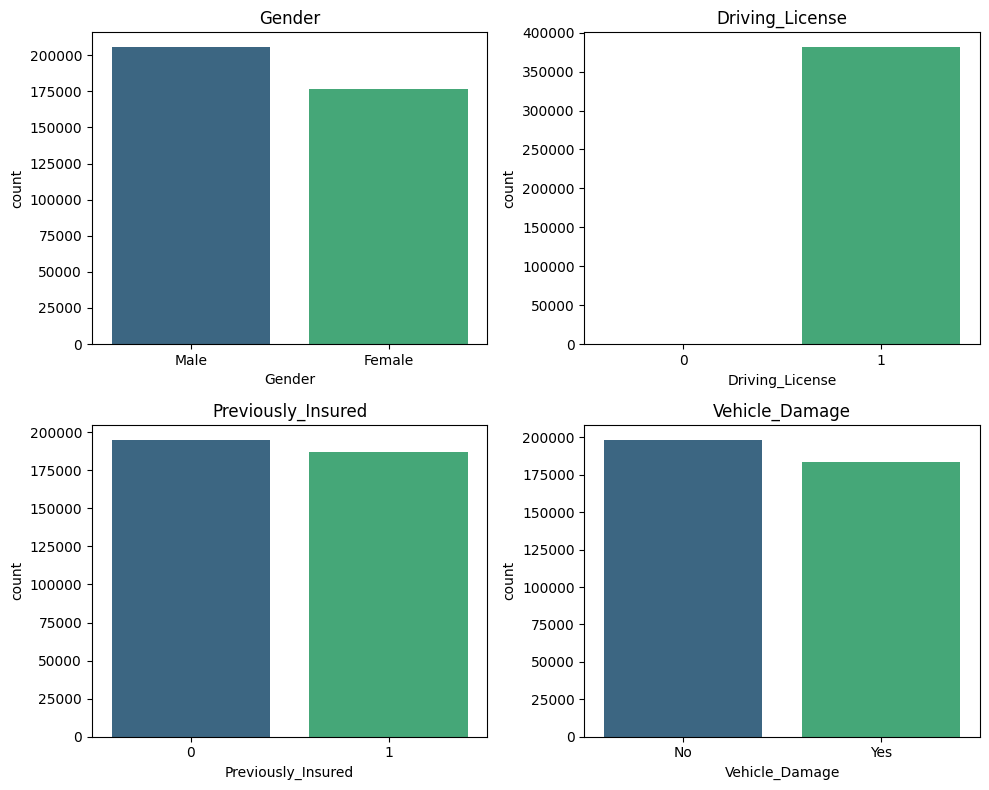

In [ ]:
cat_col = ['Gender', 'Driving_License','Previously_Insured', 'Vehicle_Damage']

fig, axes = plt.subplots(2, 2, figsize = (10,8))
axes = axes.flatten()

for col, ax in zip(cat_col, axes):
  sns.countplot(x = col, data = df, ax = ax, hue = col, legend = False,
                palette = 'viridis')
  ax.set_title(col)

plt.tight_layout()

Overall, the features are balanced. The exception is Driving_License because almost all clients have a driver's license

The distribution of target

<Axes: xlabel='Response', ylabel='count'>

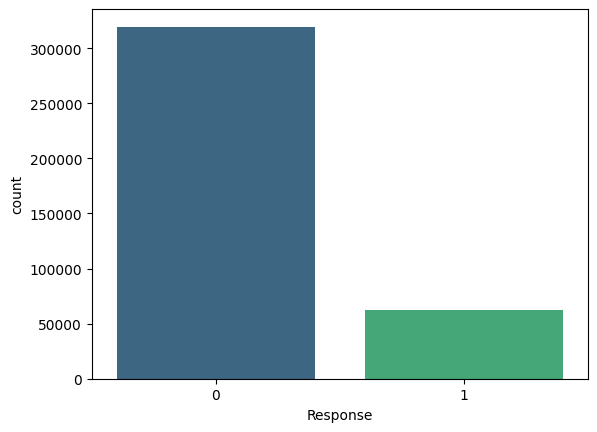

In [ ]:
sns.countplot(x = 'Response', data = df, hue = 'Response', legend = False, palette = 'viridis')

We can observe a significant dominance of class 0, which may negatively affect the prediction model's performance

**Performing data transformation**

Now we need to encode categorical variables so that the machine can understand them. Let's use Pandas' *get_dummies* to convert these categorical variables into multiple binary columns.  

In [ ]:
X = df.drop(['Response'], axis = 1)
y = df['Response']

In [ ]:
X = pd.get_dummies(X, dtype = int, drop_first = True)
X.head()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Gender_Male,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_Yes
0,167647,22,1,7.0,1,2630.0,152.0,16,1,1,0,0
1,17163,42,1,28.0,0,43327.0,26.0,135,1,0,0,1
2,32023,66,1,33.0,0,35841.0,124.0,253,0,0,0,1
3,87447,22,1,33.0,0,27645.0,152.0,69,0,1,0,0
4,501933,28,1,46.0,1,29023.0,152.0,211,1,1,0,0


Normalizing numerical variables

Let's use *MinMaxScaler* to scale all data features in range [0, 1]

In [ ]:
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(X)

In [ ]:
X = pd.DataFrame(scaled_features, columns = X.columns)

In [ ]:
X.head()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Gender_Male,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_Yes
0,0.329918,0.030769,1.0,0.134615,1.0,0.000000,0.932099,0.020761,1.0,1.0,0.0,0.0
1,0.033774,0.338462,1.0,0.538462,0.0,0.075710,0.154321,0.432526,1.0,0.0,0.0,1.0
2,0.063018,0.707692,1.0,0.634615,0.0,0.061784,0.759259,0.840830,0.0,0.0,0.0,1.0
3,0.172089,0.030769,1.0,0.634615,0.0,0.046537,0.932099,0.204152,0.0,1.0,0.0,0.0
4,0.987775,0.123077,1.0,0.884615,1.0,0.049100,0.932099,0.695502,1.0,1.0,0.0,0.0


# **Creating and training the model**

Split our data to train and test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

We are going to use Logistic Regression, KNN, Decision Tree and Random Forest classifiers to evaluate the prediction quality without oversampling. Since all of them solve classification problems, we need to check how sensitive each model is to class imbalance. Let's write a function that will help us apply all these models efficiently and get an accuracy, a classification report, which allows us to examine metrics like precision, recall, F1-score for each class and a confusion matrix, which lets us see how many instances were correctly or incorrectly classified for each class

In [ ]:
def predictionModels(x, y, x_test = X_test, y_test = y_test):
  models = [
    LogisticRegression(random_state=42),
    KNeighborsClassifier(),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42)
    ]

  for model in models:
    model.fit(x,y)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'\n{model.__class__.__name__} Accuracy: {accuracy}')
    print(f'\n{model.__class__.__name__} Classification Report:')
    print(classification_report(y_test, y_pred))
    print(f'\n{model.__class__.__name__} Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))

In [ ]:
predictionModels(X_train, y_train)


LogisticRegression Accuracy: 0.8763708161857411

LogisticRegression Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93    105365
           1       0.69      0.46      0.55     20746

    accuracy                           0.88    126111
   macro avg       0.79      0.71      0.74    126111
weighted avg       0.86      0.88      0.87    126111


LogisticRegression Confusion Matrix:
[[101011   4354]
 [ 11237   9509]]

KNeighborsClassifier Accuracy: 0.8777822711738072

KNeighborsClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93    105365
           1       0.68      0.49      0.57     20746

    accuracy                           0.88    126111
   macro avg       0.79      0.72      0.75    126111
weighted avg       0.87      0.88      0.87    126111


KNeighborsClassifier Confusion Matrix:
[[100625   4740]
 [ 10673  10073]]

DecisionT

# **Handling an imbalanced class**

We need to adjust the balance between minority and majority classes. While undersampling can remove essencial data examples, oversampling may be a better approach to address this issue

**Smote:**

SMOTE works by utilizing a k-nearest neighbor algorithm to create synthetic data. In plain words, SMOTE looks at the samples of the minority class, picks one of its nearest neighbors, and then creates a new synthetic sample somewhere between them in the feature space. We will see this visually on a scatter plot a bit later

In [ ]:
smote = SMOTE(random_state = 0)

X_smt_train, y_smt_train = smote.fit_resample(X_train,y_train)

In [ ]:
y_smt_train.value_counts()

,count
Response,
0,214188
1,214188


Class balance has been restored. Let's evaluate our models’ predictions by checking the classification report, confusion matrix, and accuracy to see how well each model performs

In [ ]:
predictionModels(X_smt_train, y_smt_train)


LogisticRegression Accuracy: 0.7444156338463734

LogisticRegression Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.71      0.82    105365
           1       0.38      0.92      0.54     20746

    accuracy                           0.74    126111
   macro avg       0.68      0.82      0.68    126111
weighted avg       0.88      0.74      0.78    126111


LogisticRegression Confusion Matrix:
[[74738 30627]
 [ 1605 19141]]

KNeighborsClassifier Accuracy: 0.8013258161460936

KNeighborsClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.81      0.87    105365
           1       0.44      0.75      0.56     20746

    accuracy                           0.80    126111
   macro avg       0.69      0.78      0.71    126111
weighted avg       0.86      0.80      0.82    126111


KNeighborsClassifier Confusion Matrix:
[[85425 19940]
 [ 5115 15631]]

DecisionTreeClass

**Adasyn:**

This method is similar to SMOTE but it generates different number of samples depending on an estimate of the local distribution of the class to be oversampled

In [ ]:
ad = ADASYN(random_state = 0)

X_ad_train, y_ad_train = ad.fit_resample(X_train, y_train)

In [ ]:
y_ad_train.value_counts()

,count
Response,
0,214188
1,210167


In [ ]:
predictionModels(X_ad_train, y_ad_train)


LogisticRegression Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.65      0.78    105365
           1       0.35      0.98      0.52     20746

    accuracy                           0.70    126111
   macro avg       0.67      0.82      0.65    126111
weighted avg       0.89      0.70      0.74    126111


LogisticRegression Confusion Matrix:
[[68052 37313]
 [  325 20421]]

KNeighborsClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.78      0.86    105365
           1       0.42      0.79      0.55     20746

    accuracy                           0.79    126111
   macro avg       0.68      0.79      0.70    126111
weighted avg       0.86      0.79      0.81    126111


KNeighborsClassifier Confusion Matrix:
[[82656 22709]
 [ 4353 16393]]

DecisionTreeClassifier Classification Report:
              precision    recall  f1-score   support

           0    

# **Comparing data before and after balancing**

In [ ]:
df_smt = pd.concat([X_smt_train, y_smt_train], axis = 1)
df_ad = pd.concat([X_ad_train, y_ad_train], axis = 1)

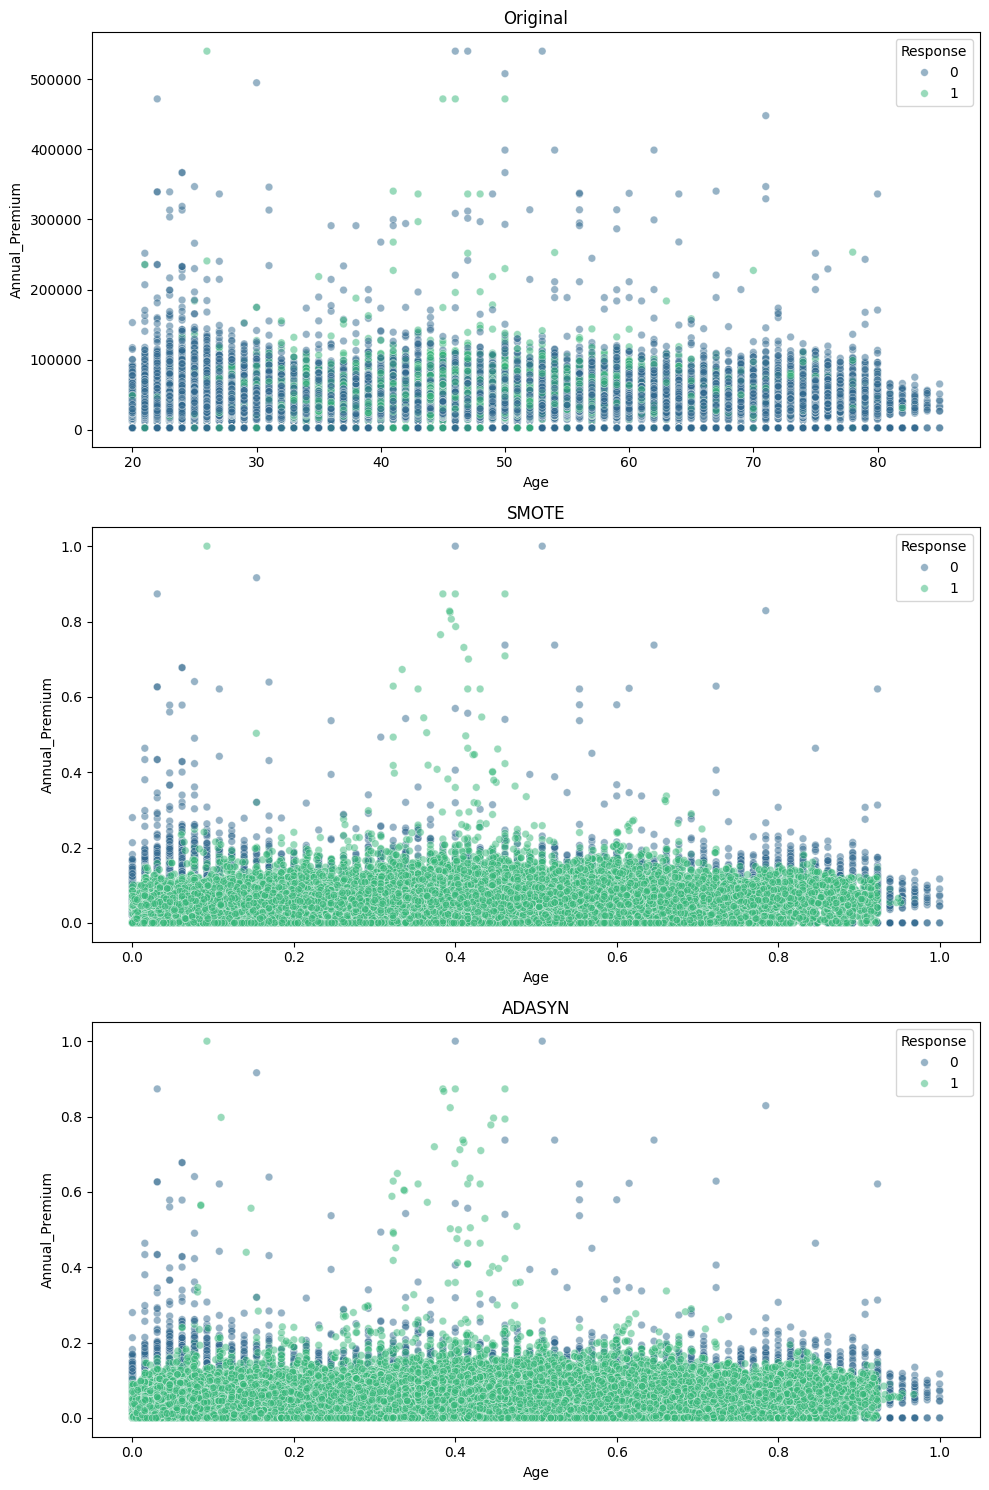

In [ ]:
dfs = [df, df_smt, df_ad]
titles = ['Original', 'SMOTE', 'ADASYN']

fig, axes = plt.subplots(3, 1, figsize = (10, 15))
axes = axes.flatten()

for df_name, ax, title in zip(dfs, axes, titles):
  sns.scatterplot(x = 'Age', y = 'Annual_Premium', data = df_name, hue = 'Response',
                  palette = 'viridis', ax = ax, alpha = 0.5, s = 30)

  ax.set_title(title)

plt.tight_layout()